In [1]:
import numpy as np 
from functions import *
import structures as st
from sklearn.datasets import make_spd_matrix

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from skimage.restoration import denoise_tv_chambolle

#loading dataset

# Construct a tf.data.Dataset
(train, test), info = tfds.load(
    'mnist',
    #split=['train', 'test'],
    split = ['train[:70%]', 'train[70%:]'],
    shuffle_files=True,
    as_supervised=True,
    
    with_info=True,
)

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

train = train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
train = train.cache()
train = train.shuffle(info.splits['train'].num_examples)
LN = int(len(train)//5)
train = train.batch(LN)
train = train.prefetch(tf.data.AUTOTUNE)

LN_test = int(len(test)//5)
test = test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test = test.batch(LN_test)
test = test.cache()
test = test.prefetch(tf.data.AUTOTUNE)

for example in train.take(1):
    image, label = 1 - example[0], example[1]

for example in test.take(1):
    image2, label = 1 - example[0], example[1]

2025-03-31 19:27:30.317627: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-31 19:27:36.155345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-31 19:27:36.332107: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-03-31 19:27:36.332251: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did n

In [2]:
from noise_functions import add_spnoise, add_noise
dataset = []
noise_level = np.sqrt(0.005)
prob = 0.3
noisies = []
for i, img in enumerate(image):
    noisy = add_spnoise(img.numpy().reshape(28,28).copy(), noise_level, prob).reshape(28,28)
    noisy = (noisy - noisy.min())/(noisy.max() - noisy.min())
    im = img.numpy().reshape(28,28)
    im = (im - im.min())/(im.max() - im.min())
    dataset.append([img.numpy().reshape(28,28), noisy])
    noisies.append(noisy)
        

dataset_test = []
noisies_test = []
for i, img in enumerate(image2):
    noisy = add_spnoise(img.numpy().reshape(28,28).copy(), noise_level, prob).reshape(28,28)
    noisy = (noisy - noisy.min())/(noisy.max() - noisy.min())
    im = img.numpy().reshape(28,28)
    im = (im - im.min())/(im.max() - im.min())
    dataset_test.append([img.numpy().reshape(28,28), noisy])
    noisies_test.append(noisy)

In [3]:
from sklearn.decomposition import SparsePCA, PCA, KernelPCA
n = 3
digits = PCA(n_components=n**2)
digits.fit([noisy.reshape(28*28) for noisy in noisies])

#fig, axes = plt.subplots(n,n,figsize=(9,9), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.0, wspace=0.01))
#for i, ax in enumerate(axes.flat):
#    ax.imshow(digits.components_[i].reshape(28,28),cmap='gray')

PCA(n_components=9)

In [4]:
transformed = digits.transform([test.reshape(28*28) for test in noisies])

In [5]:
def proj_pos(A):

    d, O = np.linalg.eigh(A)

    return O@np.diag(np.maximum(d, 0))@O.T

In [6]:
def denoise_unsupervised(noisy, verbose):
    initial_Phi = [make_spd_matrix(n**2)/100 for _ in range(n**2)]
    TV_Ls = [TV(digits.components_[i].reshape(28,28)) for i in range(n ** 2)]
    kappa = 1
    L = 15
    p = 12
    v0 = im_dual(noisy)
    Sigma = [0 * phi for phi in initial_Phi]
    tilde_Phi = initial_Phi.copy()
    Lxi = digits.transform([noisy.reshape(28*28)])

    alpha = 0 
    for i, phi in enumerate(initial_Phi):
        val = (Lxi @ phi @ Lxi.T) * TV_Ls[i]
        alpha += val 
    alpha = alpha[0][0]
    #print(f'Initial Alpha: {alpha}')
    v = v0
    Phi = initial_Phi.copy()

    k = 0 
    max_its = 500
    tv = TV(noisy)#TV(dataset[s][0])
    for k in range(max_its):
        for i, phi in enumerate(Phi):
            sigma = phi - 1/kappa * (tv * TV_Ls[i] - TV(div(im_dual(v) + noisy)))
            tilde_Phi[i] = proj_pos(sigma)
            tilde_v = v 
            
        alpha = 0 
        for i, phi in enumerate(Phi):
            val = (Lxi @ phi @ Lxi.T) * TV_Ls[i]
            alpha += val 
        alpha = alpha[0][0]
        for s in range(28):
            for t in range(28):
                val = np.array([tilde_v[0, s,t], tilde_v[1, s,t]])
                if val[0] !=0:
                    tilde_v[0,s,t] = (val[0]/np.linalg.norm(val)) * alpha
                elif val[1] !=0:
                    tilde_v[1,s,t] = (val[1]/np.linalg.norm(val)) * alpha

        dual = im_dual(div(v) + noisy)
        Nk = -np.trace(dual[0].T @ (v[0] - tilde_v[0])) -np.trace(dual[1].T @ (v[1] - tilde_v[1]))
        for i, phi in enumerate(Phi):
            Nk += TV_Ls[i] * np.trace(phi.T @ (phi - tilde_Phi[i]))

        Bk = 0
        for i, phi in enumerate(Phi):
            Bk += L * kappa * np.linalg.norm(phi - tilde_Phi[i]) ** 2
        theta_k = min(1, Nk/Bk)

        v = v + theta_k * (tilde_v - v) 
        for i, phi in enumerate(Phi):
            Phi[i] = phi + theta_k * (tilde_Phi[i] - phi)
        
        k += 1
        if verbose:
            if k % int(max_its//10) == 0:
                print(f'{int(10 * k/(int(max_its//10)))}%, Alpha: {alpha}')
    
    denoised_img = denoise_tv_chambolle(noisy, 1/alpha)
    return denoised_img

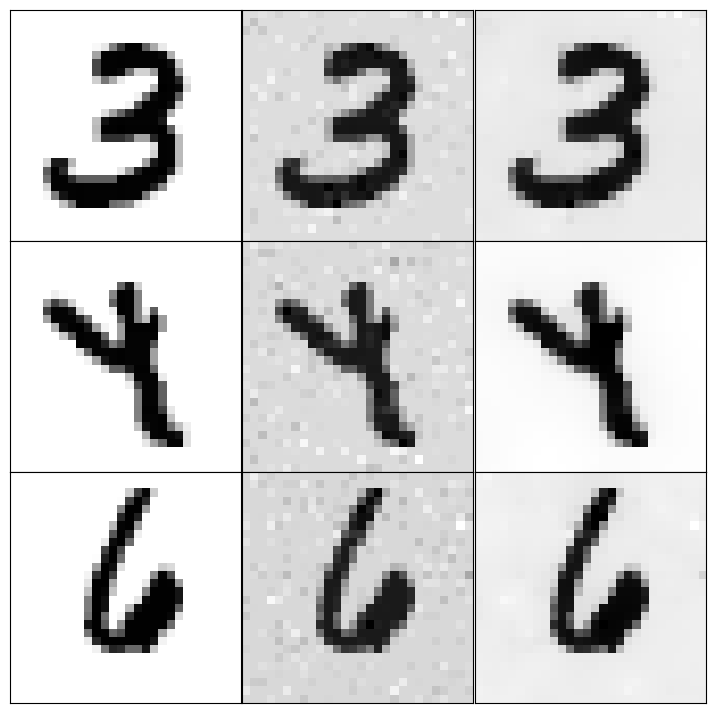

In [7]:
x = 65
y = 19
z = 44

fig, axes = plt.subplots(nrows = 3, ncols = 3,figsize=(18,9), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0, wspace=-0.75))
axes[0,0].imshow(dataset_test[x][0], cmap = 'grey')
axes[1,0].imshow(dataset_test[y][0], cmap = 'grey')
axes[2,0].imshow(dataset_test[z][0], cmap = 'grey')

axes[0,1].imshow(dataset_test[x][1], cmap = 'grey')
axes[1,1].imshow(dataset_test[y][1], cmap = 'grey')
axes[2,1].imshow(dataset_test[z][1], cmap = 'grey')

axes[0,2].imshow(denoise_unsupervised(dataset_test[x][1], False), cmap = 'grey')
axes[1,2].imshow(denoise_unsupervised(dataset_test[y][1], False), cmap = 'grey')
axes[2,2].imshow(denoise_unsupervised(dataset_test[z][1], False), cmap = 'grey')